# Problem 1

**Bagged Decision Tree**

In this homework you are gonna learn 2 things how to use all processor on your machine(in python) and Bagged(Bootstrap Aggregating) Decision Tree.

Bagging(Bootstrap Aggregating) is a common way to prevent overfitting. The idea is to make a bunch of trees. Each with a handicapped data. To handicap the data, one could either use just the subset or just remove some features.

Then after you get a bunch of classifiers(trees) all we need to do is average the output.

Consider the following data write a Bagged Decision Tree out of it.

- For each tree use roughly half the sample randomly pick data (`np.random.choice` is your friend).
- Use minleaf of 20 or so.
- Train 100 trees.
- Make contour plot.

In [1]:
%matplotlib inline
import numpy as np
import math
from matplotlib import pyplot as plt

(-5, 5)

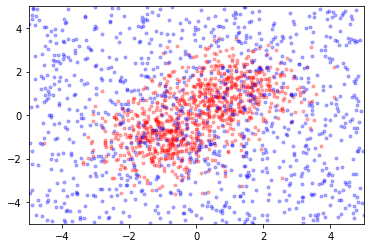

In [2]:
np.random.seed(1234)
nset = 500
xp11 = np.random.randn(nset,1)-1
xp21 = np.random.randn(nset,1)-1

xp12 = np.random.randn(nset,1)+1
xp22 = np.random.randn(nset,1)+1

xp1 = np.concatenate((xp11, xp12))
xp2 = np.concatenate((xp21, xp22))

pcls = np.zeros((nset*2))
pcls[:] = 1

xn1 = np.random.random((nset*2,1))*10-5
xn2 = np.random.random((nset*2,1))*10-5
ncls = np.zeros((1000))
ncls[:] = -1

x1s = np.concatenate([xp1, xn1])
x2s = np.concatenate([xp2, xn2])
cls = np.concatenate([pcls, ncls])
features = np.concatenate((x1s, x2s), axis=1)

cls>0
plt.plot(features[cls>0, 0], features[cls>0, 1], '.r', alpha=0.3)
plt.plot(features[cls<0, 0], features[cls<0, 1], '.b', alpha=0.3)
plt.xlim(-5, 5)
plt.ylim(-5, 5)


In [164]:
import pydot
from IPython.display import Image, display

def visualize_tree(node, depth_limit=10):
    graph = pydot.Dot(graph_type='digraph')
    visualize_tree_helper(node, graph, 0, depth_limit=depth_limit)
    display(Image(graph.create_png()))
    return graph
    
def visualize_tree_helper(node, graph, depth, depth_limit=10):
    
    if depth > depth_limit:
        print('Traversing too deep')
        dotnode = pydot.Node('n%d'%id(node), label=str(node), shape="diamond", fillcolor="green", style="filled")
        graph.add_node(dotnode)
        return dotnode
      
    if not node.is_leaf():
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="box")
    else:
        dotnode = pydot.Node('n%d'%id(node),label=str(node), shape="ellipse")
    graph.add_node(dotnode)
    
    if node.left is not None:
        dotleft = visualize_tree_helper(node.left, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotleft, label="Y")
        graph.add_edge(edge)
    if node.right is not None:
        dotright = visualize_tree_helper(node.right, graph, depth+1, depth_limit)
        edge = pydot.Edge(dotnode, dotright, label="N")
        graph.add_edge(edge)
    return dotnode

In [2]:
class Node:
    def __init__(self, msg='label'):
        self.left = None
        self.right = None
        self.msg = msg
        
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def __str__(self):
        return self.msg

In [3]:
from typing import List

class DecisionNode(Node):
    def __init__(self, vid:int, cut:float, prob=-1.0):
        Node.__init__(self)
        self.vid = vid
        self.cut = cut
        self.prob = prob
    
    def classify(self, features:List[int]) -> float:
        if self.is_leaf(): # base case
            return self.prob
        
        if features[self.vid] < self.cut:
            return self.left.classify(features)
        else:
            return self.right.classify(features)
    
    def __str__(self):
        if not self.is_leaf():
            return 'x%d < %.2f'%(self.vid, self.cut)
        else:
            return '%.2f'%self.prob

In [4]:
def make_leaf(data, cls) -> DecisionNode:
    n_red = len(data[cls < 0])
    total = len(data)
    return DecisionNode(None, None, n_red/total)

def find_best_cut(data, cls) -> DecisionNode:
    n_var = len(data[0])
    best_score = 0
    best_vid = 0
    best_cut = 0
    first = True
    for vid in range(n_var):
        feat = data[:, vid]
        cuts = np.linspace(np.min(feat), np.max(feat), 10)[1:-1]
        
        for cut in cuts:
            score = compute_score(data, cls, vid, cut)
            if first or score > best_score:
                first = False
                best_score = score
                best_vid = vid
                best_cut = cut
    return DecisionNode(best_vid, best_cut)
    
def compute_score(data, cls, vid, cut) -> float:
    dl, cl, dr, cr = split_data(data, cls, vid, cut)
    
    def one_side_score(data, cls):
        n_red = np.sum(cls < 0)
        total_n = len(cls)
        p_red = n_red/total_n
        return (p_red - 0.5)**2
    
    return one_side_score(dl, cl) + one_side_score(dr, cr)
    
def split_data(data, cls, vid, cut) -> 'data_left, cls_left, data_right, cls_right':
    left_mask = data[:, vid] < cut
    right_mask = ~left_mask
    return data[left_mask], cls[left_mask], data[right_mask], cls[right_mask]

def make_decision_tree(data, cls, min_leaf_size = 5):
    # if should terminate:
    #       return leaf
    if len(data) <= min_leaf_size: # should terminate
        return make_leaf(data, cls) # return leaf
    
    # find best cut
    this_node = find_best_cut(data, cls)
    
    # get left and right data
    dl, cl, dr, cr = split_data(data, cls, this_node.vid, this_node.cut)
    
    # left = tree your friend made with left data
    this_node.left = make_decision_tree(dl, cl, min_leaf_size)
    
    # right = tree your friend made with right data
    this_node.right = make_decision_tree(dr, cr, min_leaf_size)
    
    return this_node

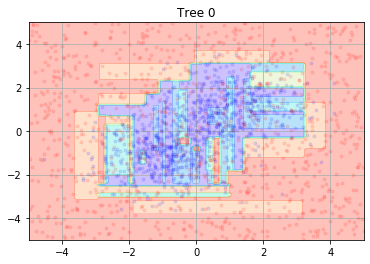

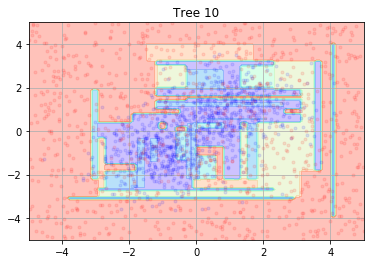

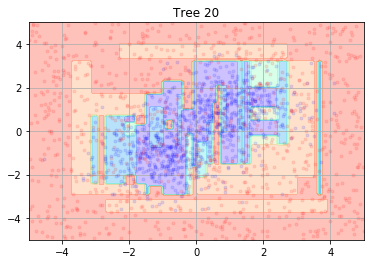

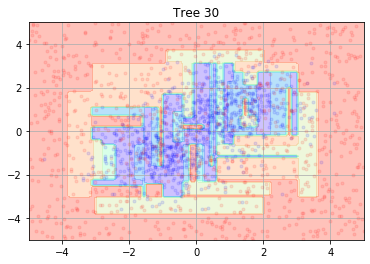

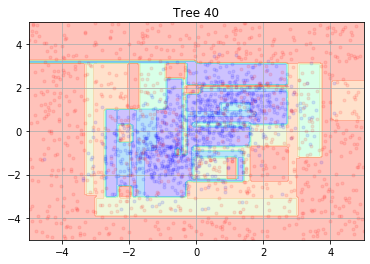

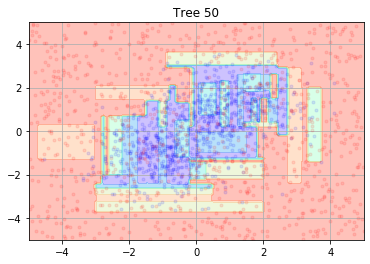

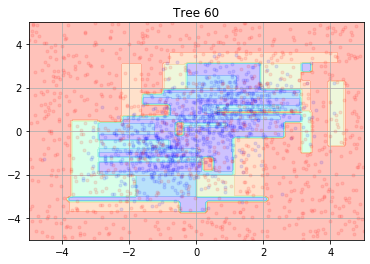

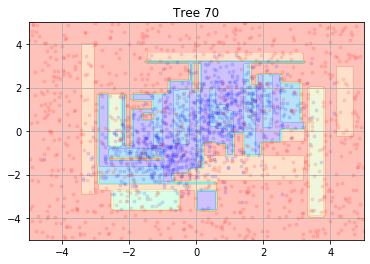

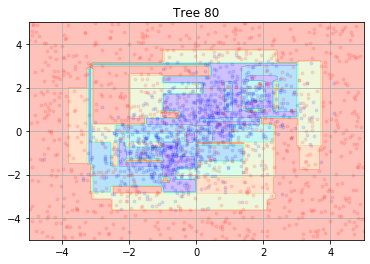

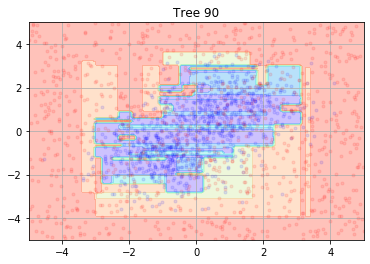

In [46]:
size = int(len(cls)/2)
random = np.random.choice(len(cls), (100, size))

trees = []
for i in range(100):
    sample_features = features[random[i]]
    sample_cls = cls[random[i]]
    
    root = make_decision_tree(sample_features, sample_cls, 20)
    trees.append(root)
    
    if i % 10 == 0:
        plt.figure()
        plt.title('Tree {}'.format(i))
        x1s = np.linspace(-5,5,100)
        x2s = np.linspace(-5,5,100)
        zs = np.zeros((100,100))
        for ix1, x1 in enumerate(x1s):
            for ix2, x2 in enumerate(x2s):
                zs[ix1, ix2] = root.classify([x1, x2])
        plt.contourf(x1s, x2s, zs.T, cmap='rainbow', alpha=0.3)
        plt.plot(features[cls>0,0], features[cls>0,1], '.b', alpha=0.1)
        plt.plot(features[cls<0,0], features[cls<0,1], '.r', alpha=0.1)
        plt.grid(True)

## 1.2 
Parallelize your code

You can see that training 100 trees takes quite a while. In this problem your job is to modify your code a little bit so that it uses all processor on your machine.

**Save often. There is a chance it will crash your computer.**

https://docs.python.org/2/library/multiprocessing.html

Be careful about np.random.rand in multiprocessing environment. Pass the seed to each process. https://stackoverflow.com/questions/24345637/why-doesnt-numpy-random-and-multiprocessing-play-nice

In [14]:
from multiprocessing import Pool

def f(x):
    return x*x

p = Pool(5)
print(p.map(f, [1, 2, 3]))
p.close()

[1, 4, 9]


# Problem 2

**Regression Tree**

In the class we learned how to make classification tree which return probability of being of one class.

We can extend this idea so that it can do regression; outputting number from $-\infty$ to $\infty$.

Here is the idea. We want to carve out the a region and return the **mean** of the **value** in that region.
<img src="regressiontree.png"/>

## 2.1
Given that we want to return the **mean** of the data in in the region. This means that a good region split should make the **mean** of each region close to the value of the data in the corresponding region.

With this basic idea. Write down how to calculate the score for the split.

In [ ]:
# sum((i - mean(x))^2 for i in x) where x is the data within a region

## 2.2
Consider the following data. Build a regression tree to prdict the `z` value.

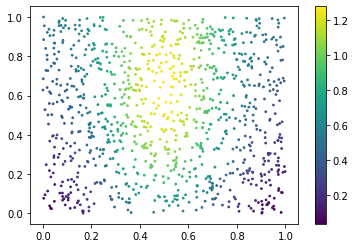

In [5]:
import numpy as np
from matplotlib import pyplot as plt
ndata = 1000
x = np.random.rand(ndata)
y = np.random.rand(ndata)
z = np.exp(-(x-0.5)**2/2/0.2**2 + -(y-0.5)**2/2/0.5**2)+0.5*y
plt.scatter(x,y, c=z,s=3)
plt.colorbar()

In [27]:
z

array([0.37993099, 0.91248326, 0.2659829 , 0.50911579, 0.40492633,
       0.84926564, 0.49764875, 0.70801579, 1.20046361, 0.98752644,
       0.2992436 , 1.26274812, 1.19022805, 0.80965054, 0.3105691 ,
       1.06363724, 1.27686976, 0.37894434, 1.08399868, 0.40931158,
       0.87866298, 0.69343164, 1.25949442, 1.04326232, 0.65135019,
       1.16782751, 0.658516  , 1.04077716, 1.24070233, 0.61400986,
       0.5079132 , 1.18770207, 0.47971996, 1.02803528, 1.23475701,
       0.93494795, 0.23205216, 0.44828854, 0.89152751, 0.07307539,
       0.05748104, 0.93204238, 0.38818817, 0.42622523, 1.03186813,
       0.4935229 , 1.00927103, 0.42373199, 0.61345475, 0.41079874,
       0.93034549, 0.44343582, 0.27406627, 0.87376223, 0.47737308,
       0.36338873, 0.57830659, 0.6196142 , 0.49885851, 0.7594983 ,
       0.20482257, 0.1583258 , 0.86822322, 0.26420324, 0.32135106,
       0.29154673, 0.76033481, 0.56318923, 0.84548606, 0.63438112,
       0.63385714, 1.05105577, 1.07475331, 0.38476104, 0.70260

In [172]:
def make_leaf(data, cls) -> DecisionNode:
    return DecisionNode(None, None, np.mean(data))

def find_best_cut(data, cls) -> DecisionNode:
    n_var = len(data)
    best_score = 0
    best_vid = 0
    best_cut = 0
    first = True
    for vid in range(n_var):
        feat = data
        cuts = np.linspace(np.min(feat), np.max(feat), 10)[1:-1]
        
        for cut in cuts:
            score = compute_score(data, cls, vid, cut)
            if first or score < best_score:
                first = False
                best_score = score
                best_vid = vid
                best_cut = cut
    return DecisionNode(best_vid, best_cut)
    
def compute_score(data, cls, vid, cut) -> float:
    dl, cl, dr, cr = split_data(data, cls, vid, cut)
    
    def mse(data, cls):
        data_std = np.std(data)
        return data_std
    
    return mse(dl, cl) + mse(dr, cr)
    
def split_data(data, cls, vid, cut) -> 'data_left, cls_left, data_right, cls_right':
    left_mask = data < cut
    right_mask = ~left_mask
    return data[left_mask], cls[left_mask], data[right_mask], cls[right_mask]

def make_regression_tree(data, cls, min_leaf_size = 5):
    # if should terminate:
    #       return leaf
#     print(len(data))
    if len(data) <= min_leaf_size: # should terminate
        return make_leaf(data, cls) # return leaf
    
    # find best cut
    this_node = find_best_cut(data, cls)
    
    # get left and right data
    dl, cl, dr, cr = split_data(data, cls, this_node.vid, this_node.cut)
#     print(len(dl), len(cl), len(dr), len(cr))
    
    # left = tree your friend made with left data
    this_node.left = make_regression_tree(dl, cl, min_leaf_size)
    
    # right = tree your friend made with right data
    this_node.right = make_regression_tree(dr, cr, min_leaf_size)
    
    return this_node


In [173]:
root = make_regression_tree(x, y, 100)

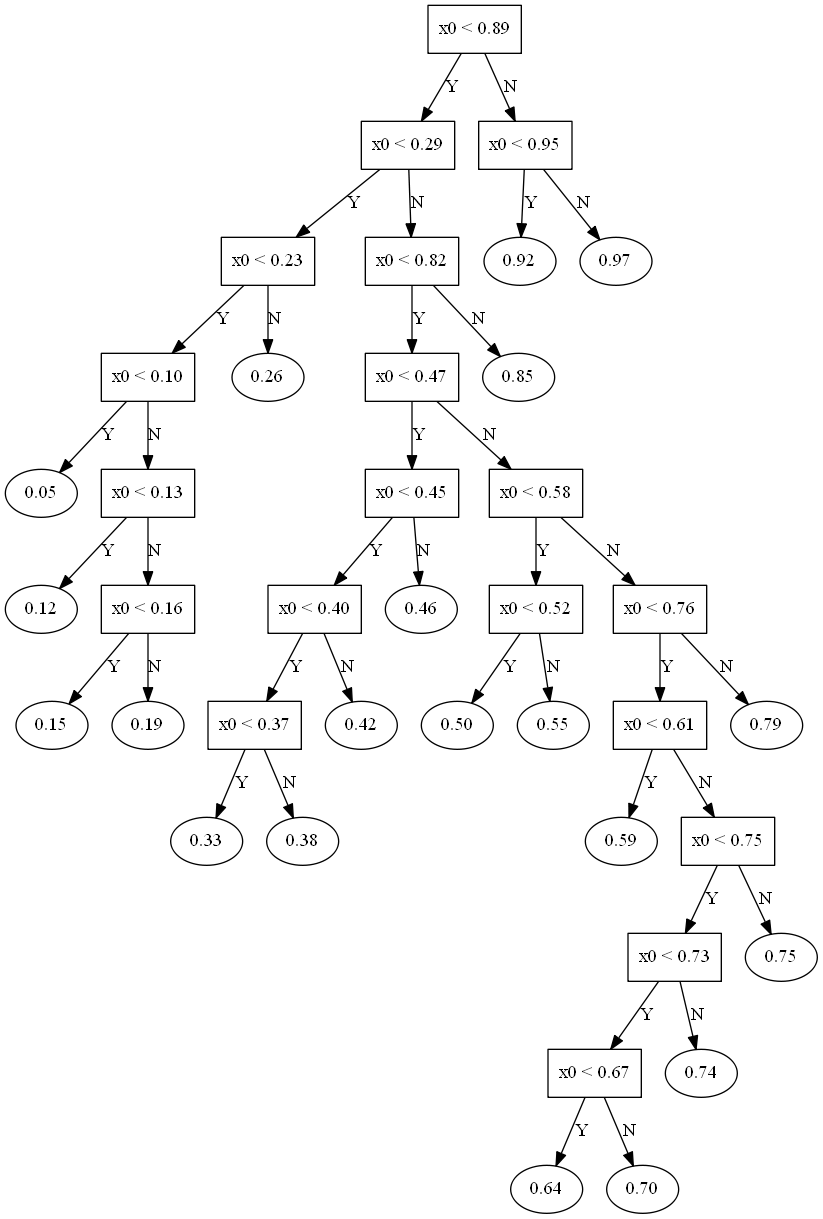

In [174]:
visualize_tree(root)

In [134]:
def predict_one(val, root):
#     if root.right is None and root.left is None:
#         return root.cut
    
    if val < root.cut:
        if root.left.cut is not None:
#             print("at left")
            return predict_one(val, root.left)
        else: return root.left.prob
#     else : return root.cut
    elif val >= root.cut:
        if root.right.cut is not None:
#             print("at right")
#             print(root.right is not None)
            return predict_one(val, root.right)
        else: return root.right.prob
    else: 
        return root.prob

def predict(data, tree):
    return np.array([predict_one(x, tree) for x in data])

In [52]:
print(root)

x0 < 0.44


In [175]:
# print(predict_one(z[5], root))
test_result = predict(z, root)

In [ ]:
for i, val in enumerate(z):
    if val > 0.6: print(i, val)

In [55]:
print(test_result[0], z[0])

0.8527409725272551 0.8543206401759705


In [176]:
print(np.mean(test_result)/np.mean(z))

0.9437979703783598


In [177]:
test_result

array([0.8513354 , 0.8513354 , 0.91800955, 0.97303494, 0.97303494,
       0.64220767, 0.97303494, 0.91800955, 0.55192833, 0.8513354 ,
       0.79107582, 0.69921512, 0.45756467, 0.42191218, 0.55192833,
       0.55192833, 0.55192833, 0.97303494, 0.64220767, 0.8513354 ,
       0.38437081, 0.0521953 , 0.4961735 , 0.55192833, 0.26105556,
       0.79107582, 0.33440877, 0.79107582, 0.97303494, 0.42191218,
       0.19484888, 0.8513354 , 0.59211749, 0.8513354 , 0.91800955,
       0.73652597, 0.97303494, 0.55192833, 0.79107582, 0.59211749,
       0.97303494, 0.97303494, 0.97303494, 0.79107582, 0.42191218,
       0.26105556, 0.4961735 , 0.97303494, 0.55192833, 0.69921512,
       0.8513354 , 0.64220767, 0.97303494, 0.33440877, 0.91800955,
       0.42191218, 0.33440877, 0.79107582, 0.33440877, 0.91800955,
       0.97303494, 0.64220767, 0.97303494, 0.42191218, 0.97303494,
       0.91800955, 0.79107582, 0.97303494, 0.97303494, 0.11549645,
       0.38437081, 0.19484888, 0.45756467, 0.55192833, 0.85133

In [58]:
root2 = make_decision_tree(x, y)

In [159]:
str(root2.left)

'x0 < 0.25'

In [158]:
str(root.left)

'x0 < 0.29'

In [160]:
predict_one(z[38], root)

0.7822518481579701

In [161]:
predict_one(z[38], root2)

0.7822518481579701